In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math
from sklearn import svm
from sklearn import mixture
from sklearn.metrics import confusion_matrix
import glob
from sklearn.decomposition import PCA

In [2]:
abdullah_training_directory = './images/Abdullah/training/'
mustafa_training_directory = './images/Mustafa/training/'
saleh_training_directory = './images/Saleh/training/'
adham_training_directory = './images/Adham/training/'

abdullah_testing_directory = './images/Abdullah/testing/'
mustafa_testing_directory = './images/Mustafa/testing/'
saleh_testing_directory = './images/Saleh/testing/'
adham_testing_directory = './images/Adham/testing/'


training_images_directories = [abdullah_training_directory, mustafa_training_directory, saleh_training_directory, adham_training_directory]
testing_images_directories = [abdullah_testing_directory, mustafa_testing_directory, saleh_testing_directory, adham_testing_directory]

training_images = []
testing_images = []

# Load the cascade for facial detection
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
# Populate Training Image list
for directory in training_images_directories:
    images = [cv2.imread(file) for file in glob.glob("{directory}*.jpg".format(directory=directory))]
    for img in images:
        training_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
        
# Populate Testing Image list
for directory in testing_images_directories:
    images = [cv2.imread(file) for file in glob.glob("{directory}*.jpg".format(directory=directory))]
    for img in images:
        testing_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

training_bounds = []

for i in range(60):
    img = training_images[i]
    # copy image
    img_disp = img.copy()

    # detect harris corners
    # cv2.cornerHarris(src, neighborhoodsize, sobelKernelSize, Harris_k)
    corners = cv2.cornerHarris(img, 2, 3, 0.04)

    # normalize corner map [0,1]
    # cv2.normalize(src, dst, alpha, beta, norm_type)
    # min_I(dst(I)) = alpha, max_I(dst(I)) = beta
    cv2.normalize(corners, corners, 0, 1, cv2.NORM_MINMAX)

    # threshold for an optimal value
    thres = 0.5

    # list all points higher than threshold
    loc = np.where(corners >= thres)
    # loop though points
    
    pts = []
    
    for pt in zip(*loc[::-1]):
        pts.append(pt)
        
        # draw filled circle on each point
        cv2.circle(img_disp, pt, 4, (255,0,0), -1)

    xs, ys = np.array(list(zip(*pts)))
    bounds_dict = {"min_x" : np.amin(xs), "min_y" : np.amin(ys), "max_x" : np.amax(xs), "max_y" : np.amax(ys)}
    training_bounds.append(bounds_dict)
    
testing_bounds = []

for i in range(56):
    img = testing_images[i]
    # copy image
    img_disp = img.copy()

    # detect harris corners
    # cv2.cornerHarris(src, neighborhoodsize, sobelKernelSize, Harris_k)
    corners = cv2.cornerHarris(img, 2, 3, 0.04)

    # normalize corner map [0,1]
    # cv2.normalize(src, dst, alpha, beta, norm_type)
    # min_I(dst(I)) = alpha, max_I(dst(I)) = beta
    cv2.normalize(corners, corners, 0, 1, cv2.NORM_MINMAX)

    # threshold for an optimal value
    thres = 0.5

    # list all points higher than threshold
    loc = np.where(corners >= thres)
    # loop though points
    
    pts = []
    
    for pt in zip(*loc[::-1]):
        pts.append(pt)
        
        # draw filled circle on each point
        cv2.circle(img_disp, pt, 4, (255,0,0), -1)

    xs, ys = np.array(list(zip(*pts)))
    bounds_dict = {"min_x" : np.amin(xs), "min_y" : np.amin(ys), "max_x" : np.amax(xs), "max_y" : np.amax(ys)}
    testing_bounds.append(bounds_dict)

In [3]:
def extract_face(img, bounds):
    """
    Function takes in an image and bounds dict and returns a face
    """
    min_x =  bounds["min_x"]
    max_x =  bounds["max_x"]
    min_y =  bounds["min_y"]
    max_y =  bounds["max_y"]
    return img[min_y:max_y, min_x:max_x]

In [4]:
# Number of Features/Eigenfaces used in PCA (optimized)
NC = 9

## Training Images

In [5]:
plt.figure(figsize=(20, 80))
training_faces = []
for i in range(60):
    img = training_images[i]
    face = extract_face(img, training_bounds[i])
    face = cv2.resize(face, (128,128))
    training_faces.append(face)
#     plt.subplot(15, 4, i+1)
#     plt.imshow(face, 'gray')    

<Figure size 1440x5760 with 0 Axes>

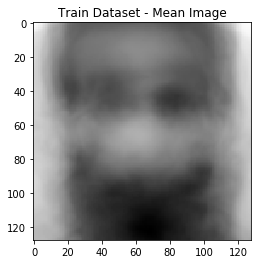

In [6]:
X_train = np.array([i.flatten() for i in training_faces])
pca = PCA(n_components=NC)
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
plt.imshow(pca.mean_.reshape(training_faces[0].shape), cmap='gray')
plt.title('Train Dataset - Mean Image');

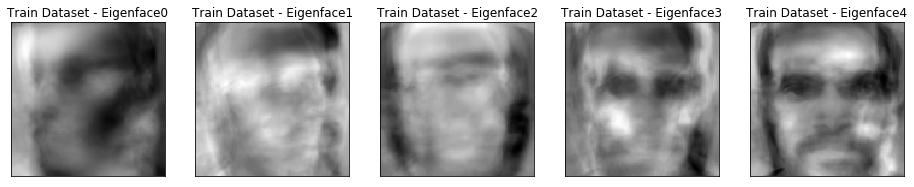

In [7]:
# Eigenfaces
fig = plt.figure(figsize=(16, 6))
for i in range(5):
    ax = fig.add_subplot(1, 5, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(training_faces[0].shape), 'gray')
    plt.title('Train Dataset - Eigenface{}'.format(i))

## Testing Images

In [8]:
# Adding the faces only to a list
testing_faces = []
for i in range(44):
    img = testing_images[i]
    face = extract_face(img, testing_bounds[i])
    face = cv2.resize(face, (128,128))
    testing_faces.append(face)

In [9]:
# Transforming test dataset using the trained PCA
X_test = np.array([i.flatten() for i in testing_faces])
X_test_pca = pca.transform(X_test)

In [10]:
# Creating labels for team members
labels = {0:'abdullah', 1:'mustafa', 2:'saleh', 3:'adham'}

# Creating correct labels for test set
y_test = np.array([[0]*14, [1]*14, [2]*14, [3]*14]).flatten()

# Creating correct labels for train set
y_train =  np.array([[0]*15, [1]*15, [2]*15, [3]*15]).flatten()

In [11]:
# List to hold 1 or 0 depending on predictions 
correct = []
for i, x_test in enumerate(X_test_pca):
    # Getting the index of the closest eigen face from the training set
    index = np.argmin(np.linalg.norm(X_test_pca[i]  - X_train_pca, axis=1))
    
    # Comparing the labels
    print('Predicted = {}\t|\tActual = {}'.format(labels[y_train[index]], labels[y_test[i]]))
    
    # Adding 1 to a list if prediction is correct
    correct.append(labels[y_train[index]] == labels[y_test[i]])


print('\nAccuracy = {:.2f}'.format(sum(correct)/len(X_test_pca)))

Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = adham	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = adham	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = mustafa	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = abdullah	|	Actual = abdullah
Predicted = saleh	|	Actual = mustafa
Predicted = saleh	|	Actual = mustafa
Predicted = saleh	|	Actual = mustafa
Predicted = saleh	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = mustafa	|	Actual = mustafa
Predicted = abd

## Number of Eigenfaces Optimization

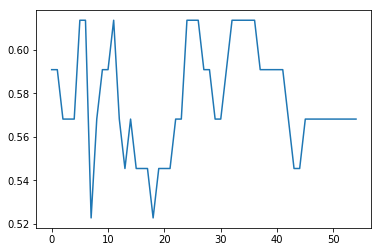

In [12]:
accuracies = []
for nc in np.linspace(4,60,55):
    nc = int(nc)
    pca = PCA(n_components=nc)
    pca.fit(X_train)
    X_train_pca = pca.transform(X_train)
    X_test_pca = pca.transform(X_test)
    # List to hold 1 or 0 depending on predictions 
    correct = []
    for i, x_test in enumerate(X_test_pca):
        # Getting the index of the closest eigen face from the training set
        index = np.argmin(np.linalg.norm(X_test_pca[i]  - X_train_pca, axis=1))

        # Adding 1 to a list if prediction is correct
        correct.append(labels[y_train[index]] == labels[y_test[i]])
    accuracies.append(sum(correct)/len(X_test_pca))
plt.plot(accuracies);